# Logistic Regression - Titanic Dataset


In [8]:
import sys
sys.path.append('..')

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.data.preprocessing import preprocess_titanic_data
from src.models.logistic_regression import LogisticRegression
from src.utils.visualization import plot_training_curves, plot_confusion_matrix, plot_feature_importance

plt.style.use('seaborn-v0_8')
torch.manual_seed(42)
np.random.seed(42)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name()}")



PyTorch version: 2.5.1
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4070 Laptop GPU


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

X_train, X_test, y_train, y_test, feature_names = preprocess_titanic_data('../data/Titanic-Dataset.csv', device=device)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Features: {X_train.shape[1]}")
print(f"Train samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Classes in y_train: {torch.unique(y_train)}")
print(f"Class distribution in y_train: {torch.bincount(y_train.int())}")
print(f"Class distribution in y_test: {torch.bincount(y_test.int())}")

print(f"X_train stats:")
print(f"Min: {X_train.min().item():.4f}")
print(f"Max: {X_train.max().item():.4f}")
print(f"Mean: {X_train.mean().item():.4f}")
print(f"Std: {X_train.std().item():.4f}")

for i in range(X_train.shape[1]):
    col = X_train[:, i]
    has_nan = torch.isnan(col).any()
    has_inf = torch.isinf(col).any()
    if has_nan or has_inf:
        print(f"Column {i}: NaN={has_nan}, inf={has_inf}")
        print(f"  Min: {col.min().item():.4f}, Max: {col.max().item():.4f}")



Device: cuda
X_train shape: torch.Size([713, 15])
X_test shape: torch.Size([178, 15])
y_train shape: torch.Size([713])
y_test shape: torch.Size([178])
Features: 15
Train samples: 713
Test samples: 178
Classes in y_train: tensor([0., 1.], device='cuda:0')
Class distribution in y_train: tensor([437, 276], device='cuda:0')
Class distribution in y_test: tensor([112,  66], device='cuda:0')
X_train stats:
Min: 0.0000
Max: 512.3292
Mean: 10.7018
Std: 24.7798


In [10]:
learning_rate = 0.001
max_epochs = 200

model = LogisticRegression(
    learning_rate=learning_rate,
    max_epochs=max_epochs,
    device=device,
    reg_type='elasticnet',
    l1_lambda=1e-2,
    l2_lambda=1e-2,
    alpha=0.5
)

print(f"Learning rate: {learning_rate}")
print(f"Max epochs: {max_epochs}")

model.fit(X_train, y_train, X_test, y_test)
print(f"Epochs: {len(model.history['train_loss'])}")
print(f"Final train loss: {model.history['train_loss'][-1]:.4f}")
if model.history['val_metrics']:
    print(f"Final val accuracy: {model.history['val_metrics'][-1]['accuracy']:.4f}")

Learning rate: 0.001
Max epochs: 200
Epochs: 200
Final train loss: 0.4526
Final val accuracy: 0.7978


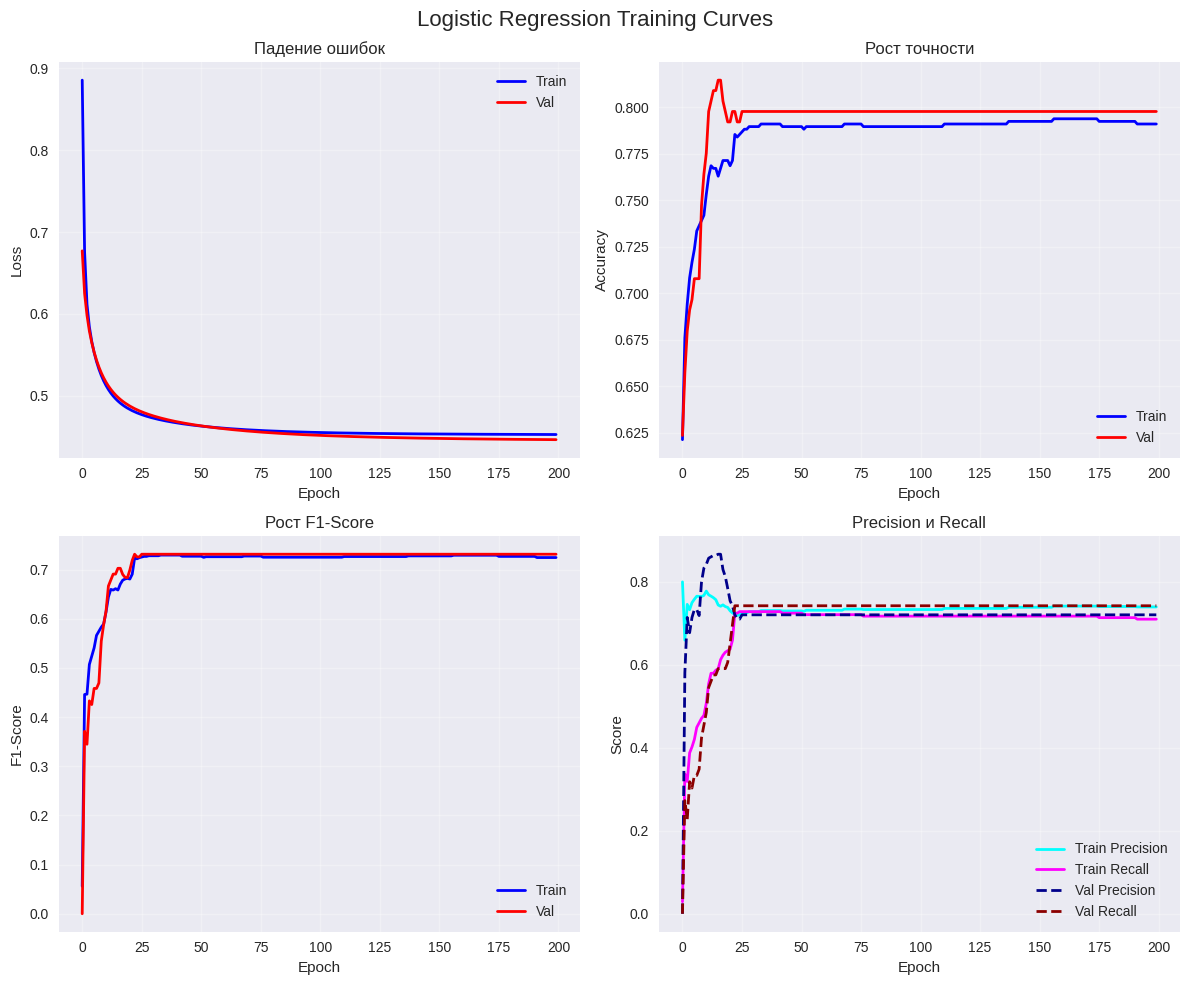

In [11]:
plot_training_curves(model.history, title="Logistic Regression Training Curves", model_type="classification")


In [12]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

test_metrics = model.score(X_test, y_test)

print("Test results:")
print(f"  Accuracy: {test_metrics['accuracy']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall: {test_metrics['recall']:.4f}")
print(f"  F1-Score: {test_metrics['f1_score']:.4f}")

baseline_pred = torch.full_like(y_test, torch.mode(y_train)[0])
baseline_accuracy = torch.mean((y_test == baseline_pred).float()).item()
print(f"\nBaseline comparison:")
print(f"  Baseline Accuracy: {baseline_accuracy:.4f}")
print(f"  Accuracy improvement: {((test_metrics['accuracy'] - baseline_accuracy) / baseline_accuracy * 100):.1f}%")

print(f"\nProbability analysis:")
print(f"  Mean survival probability: {y_pred_proba.mean().item():.4f}")
print(f"  Min probability: {y_pred_proba.min().item():.4f}")
print(f"  Max probability: {y_pred_proba.max().item():.4f}")



Test results:
  Accuracy: 0.7978
  Precision: 0.7206
  Recall: 0.7424
  F1-Score: 0.7313

Baseline comparison:
  Baseline Accuracy: 0.6292
  Accuracy improvement: 26.8%

Probability analysis:
  Mean survival probability: 0.3686
  Min probability: 0.0026
  Max probability: 0.9905


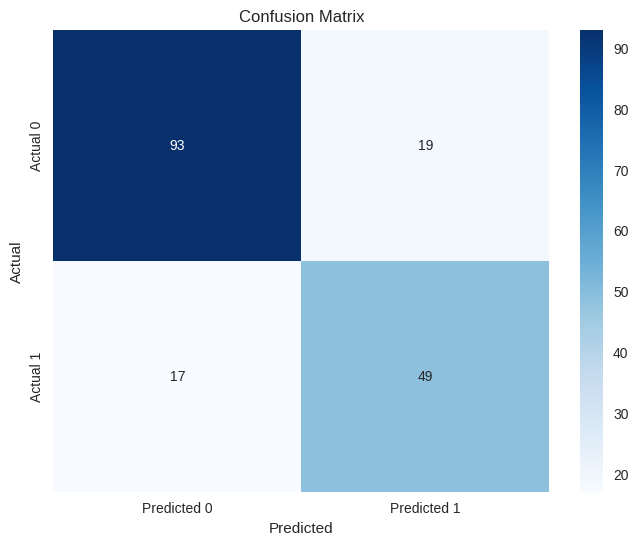

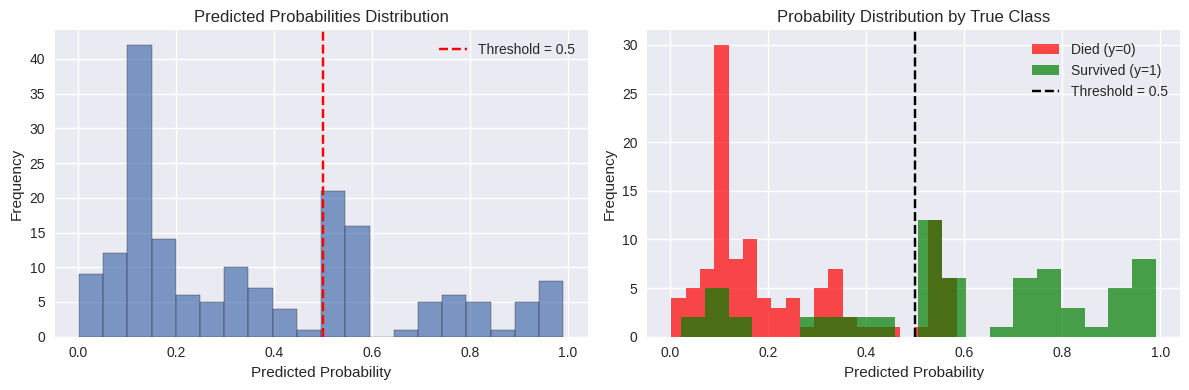

In [13]:
plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(y_pred_proba.cpu().numpy(), bins=20, alpha=0.7, edgecolor='black')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Predicted Probabilities Distribution')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
survived_probs = y_pred_proba[y_test == 1].cpu().numpy()
died_probs = y_pred_proba[y_test == 0].cpu().numpy()

plt.hist(died_probs, bins=20, alpha=0.7, label='Died (y=0)', color='red')
plt.hist(survived_probs, bins=20, alpha=0.7, label='Survived (y=1)', color='green')
plt.axvline(x=0.5, color='black', linestyle='--', label='Threshold = 0.5')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution by True Class')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Weights count: 15
X_train shape: torch.Size([713, 15])
Feature names count: 15
       Feature    Weight  Abs_Weight
9     AgeOfMan  0.076346    0.076346
7    Age*Class -0.032022    0.032022
2          Age  0.025753    0.025753
11   RichClass  0.015140    0.015140
6      IsAlone -0.014823    0.014823
10  AgeOfWoman -0.014407    0.014407
3        SibSp -0.013873    0.013873
14  Embarked_S  0.010750    0.010750
8     HighFare  0.008536    0.008536
5         Fare  0.003503    0.003503
1          Sex -0.003262    0.003262
12  Embarked_C  0.002510    0.002510
4        Parch  0.001346    0.001346
13  Embarked_Q  0.000433    0.000433
0       Pclass  0.000097    0.000097


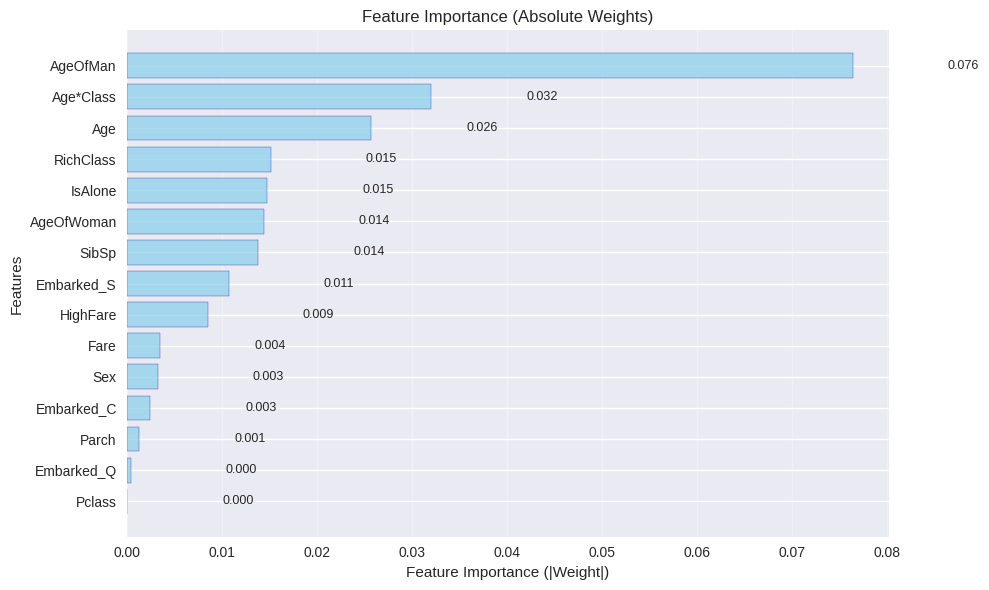


Соответствие признаков и весов:
  Pclass: 0.0001
  Embarked_Q: 0.0004
  Parch: 0.0013
  Embarked_C: 0.0025
  Sex: -0.0033
  Fare: 0.0035
  HighFare: 0.0085
  Embarked_S: 0.0108
  SibSp: -0.0139
  AgeOfWoman: -0.0144
  IsAlone: -0.0148
  RichClass: 0.0151
  Age: 0.0258
  Age*Class: -0.0320
  AgeOfMan: 0.0763
0.22280166


In [14]:
weights = model.weights.detach().numpy(force=True)
print(f"Weights count: {len(weights)}")
print(f"X_train shape: {X_train.shape}")
print(f"Feature names count: {len(feature_names)}")

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Weight': weights,
    'Abs_Weight': np.abs(weights)
}).sort_values('Abs_Weight', ascending=False)

print(feature_importance)

plot_feature_importance(weights, feature_names, title="Feature Importance (Absolute Weights)")

print(feature_importance['Abs_Weight'].sum())